In [167]:
!pip install pandas matplotlib numpy statsforecast prophet scikit-learn scipy pyarrow seaborn xgboost h2o sktime tsfresh pmdarima plotly

In [168]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [169]:
y_train_a = pd.read_parquet('A/train_targets.parquet')
y_train_b = pd.read_parquet('B/train_targets.parquet')
y_train_c = pd.read_parquet('C/train_targets.parquet')

In [170]:
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')


In [171]:
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

In [172]:
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')


# Exploratory analysis of the data

In [173]:
# add location features
X_train_estimated_a['location'] = 0
X_train_estimated_b['location'] = 1
X_train_estimated_c['location'] = 2

X_train_observed_a['location'] = 0
X_train_observed_b['location'] = 1
X_train_observed_c['location'] = 2

X_test_estimated_a['location'] = 0
X_test_estimated_b['location'] = 1
X_test_estimated_c['location'] = 2

# concat observed and estimated, then merge with y_train
X_train_a = pd.concat([X_train_estimated_a, X_train_observed_a])
X_train_b = pd.concat([X_train_estimated_b, X_train_observed_b])
X_train_c = pd.concat([X_train_estimated_c, X_train_observed_c])

In [174]:
# Print the start end end dates of the training data
X_train_estimated_a['date_forecast'].iloc[0], X_train_observed_a['date_forecast'].iloc[-1]

(Timestamp('2022-10-28 22:00:00'), Timestamp('2022-10-21 01:00:00'))

In [175]:
import warnings

import numpy as np
import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")
#warnings.resetwarnings()

In [176]:
# from sktime.registry import all_estimators

# for forecaster in all_estimators(filter_tags={"scitype:y": ["multivariate", "both"]}):
#     print(forecaster[0])

In [177]:
# import numpy as np

# from sktime.datasets import load_airline
# from sktime.forecasting.theta import ThetaForecaster

# # until fit, identical with the simple workflow
# y = load_airline()

# fh = np.arange(1, 13)

# forecaster = ThetaForecaster(sp=12)
# forecaster.fit(y, fh=fh)

In [178]:
# coverage = 0.9
# y_pred_ints = forecaster.predict_interval(coverage=coverage)
# y_pred_ints

In [179]:
# from sktime.utils import plotting

# # also requires predictions
# y_pred = forecaster.predict()

# fig, ax = plotting.plot_series(
#     y, y_pred, labels=["y", "y_pred"], pred_interval=y_pred_ints
# )

In [180]:
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline

# from sktime.datasets import load_arrow_head, load_basic_motions
# from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
# X, y = load_basic_motions(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# #  multivariate input data
# X_train.head()

In [181]:
# t = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
# Xt = t.fit_transform(X_train)

In [182]:
data_by_location = {
    'A': {'X_train': X_train_a, 'y_train': y_train_a, 'X_test': X_test_estimated_a},
    'B': {'X_train': X_train_b, 'y_train': y_train_b, 'X_test': X_test_estimated_b},
    'C': {'X_train': X_train_c, 'y_train': y_train_c, 'X_test': X_test_estimated_c},
}

# convert all datetime columns to datetime type
for location in data_by_location:
    X_train = data_by_location[location]['X_train'].copy()
    X_train['ds'] = pd.to_datetime(X_train['date_forecast'])
    X_train.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X_train.drop(columns=['date_calc'], inplace=True, errors='ignore')

    # Sort by 'date_forecast' and reset index
    X_train.sort_values(by='ds', inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    
    # Set 'date_forecast' as the index for easier resampling
    X_train.set_index('ds', inplace=True)

    # Resample to hourly and aggregate using mean
    X_train_hourly = X_train.resample('H').mean()
    X_train_hourly.reset_index(inplace=True)

    X_train_hourly.set_index('ds', inplace=True)
    # sort by index
    X_train_hourly.sort_index(inplace=True)

    data_by_location[location]['X_train'] = X_train_hourly


    # repeat for X_test
    X_test = data_by_location[location]['X_test'].copy()
    X_test['ds'] = pd.to_datetime(X_test['date_forecast'])
    X_test.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X_test.drop(columns=['date_calc'], inplace=True, errors='ignore') #TODO: use this

    # Sort by 'date_forecast' and reset index
    X_test.sort_values(by='ds', inplace=True)
    X_test.reset_index(drop=True, inplace=True)

    # Set 'date_forecast' as the index for easier resampling
    X_test.set_index('ds', inplace=True)

    # Resample to hourly and aggregate using mean
    X_test_hourly = X_test.resample('H').mean()
    X_test_hourly.reset_index(inplace=True)

    X_test_hourly.set_index('ds', inplace=True)
    # sort by index
    X_test_hourly.sort_index(inplace=True)

    data_by_location[location]['X_test'] = X_test_hourly
    




    # y_train has "time" instead
    y_train = data_by_location[location]['y_train'].copy()
    y_train['ds'] = pd.to_datetime(y_train['time'])

    y_train.drop(columns=['time'], inplace=True)

    y_train_series = y_train.squeeze()

    # set index to ds
    y_train_series.set_index('ds', inplace=True)
    y_train_series.sort_index(inplace=True)
    
    data_by_location[location]['y_train'] = y_train_series




In [183]:
# y_train = data_by_location['A']['y_train'].copy()
# y_train = y_train.squeeze()
# X_train = data_by_location['A']['X_train'].copy()

# # set index to ds
# y_train.set_index('ds', inplace=True)
# X_train.set_index('ds', inplace=True)
# # sort by index
# X_train.sort_index(inplace=True)
# y_train.sort_index(inplace=True)




In [184]:
# # date is index now
# start_date = y_train.index[0]
# end_date = y_train.index[-1]
# expected_hourly_timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# print(f"Expected hourly timestamps: {expected_hourly_timestamps}")

# missing_timestamps = expected_hourly_timestamps[~expected_hourly_timestamps.isin(y_train.index)]

# missing_timestamps

In [185]:
# # do the same for X_train, add nan values where missing timestamps are
# X_train = X_train.reindex(expected_hourly_timestamps, fill_value=np.nan)

# # check if there are any missing values
# X_train.isna().sum()

In [186]:
# from sktime.transformations.compose import TransformerPipeline
# from sktime.transformations.series.impute import Imputer
# from sklearn.impute import SimpleImputer as SklearnSimpleImputer



# # # For exogenous variables (X_train)
# # exog_imputer = SklearnSimpleImputer(strategy="mean")
# # # transform the data
# # X_train = exog_imputer.fit_transform(X_train)
# # X_train
# # check if X_train has missing values
# # drop snow_density:kgm3, cloud_base_agl:m, ceiling_height_agl:m
# X_train.drop(columns=['snow_density:kgm3', 'cloud_base_agl:m', 'ceiling_height_agl:m'], inplace=True, errors='ignore')
# X_train.isna().sum()


In [187]:
# # print all rows in X_train with missing values
# X_train[X_train.isna().any(axis=1)]

In [188]:
# # missing values in y_train
# start_date = y_train.index[0]
# end_date = y_train.index[-1]
# expected_hourly_timestamps = pd.date_range(start=start_date, end=end_date, freq='H')
# missing_timestamps = expected_hourly_timestamps[~expected_hourly_timestamps.isin(y_train.index)]
# missing_timestamps

In [189]:
# # make missing values explicit nan
# y_train = y_train.reindex(expected_hourly_timestamps)
# #num of missing values
# y_train.isna().sum()

In [190]:
# imputer = Imputer(method="drift")


# X_train = imputer.fit_transform(X=X_train, y=y_train)
# X_train.shape, y_train.shape

In [191]:

# # y_train is series
# missing_timestamps_after = expected_hourly_timestamps[~expected_hourly_timestamps.isin(X_train.index)]
# missing_timestamps_after

In [192]:
# y_train.isna().sum()

In [193]:
# # impute y_train
# df = X_train.copy()
# df.shape

In [194]:
# df['y'] = y_train

# import numpy as np
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imp_mean = IterativeImputer(random_state=0)
# df_y_imputed = imp_mean.fit_transform(df)

In [195]:
# df = pd.DataFrame(df_y_imputed)
# # get last column
# df = df.iloc[:, -1]
# # set y_train series to imputed values, and turn into series again
# #old_y_train = y_train.copy()
# y_train = pd.Series(df.values, index=X_train.index)

# # plot old and new y_train (only where missing values were)
# plt.plot(y_train, label='new')
# plt.plot(old_y_train, label='old')
# #TypeError: Indexing a Series with DataFrame is not supported, use the appropriate DataFrame column
# plt.legend()
# plt.show()


In [196]:
# # add seasonality features, day of week, hour of day, month of year
# # Adding day of the week feature
# X_train['day_of_week'] = X_train.index.dayofweek

# # Adding hour of the day feature
# X_train['hour_of_day'] = X_train.index.hour

# # Adding month of the year feature
# X_train['month_of_year'] = X_train.index.month

# # Adding quarter of the year feature, as integer (0, 1, 2, 3)
# X_train['quarter_of_year'] = X_train.index.quarter

# # Adding 'is_weekend' feature
# X_train['is_weekend'] = (X_train['day_of_week'] >= 5).astype(int)

# # Check the resulting dataframe
# X_train.head()

In [197]:
# X_train.shape, y_train.shape

In [198]:
# # drop all columns with of X_train except "direct_rad:W"
# #X_train_only_rad = X_train[['direct_rad:W', 'day_of_week', 'hour_of_day', 'month_of_year', 'quarter_of_year', 'is_weekend']]
# X_train.drop(X_train.columns.difference(['direct_rad:W', 'day_of_week', 'hour_of_day', 'month_of_year', 'quarter_of_year', 'is_weekend']), inplace=True, axis=1)


In [199]:
# X_train

In [242]:
import pandas as pd
import numpy as np
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer as SklearnSimpleImputer
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
imp_X = SimpleImputer(missing_values=np.nan, strategy='mean')

def preprocess_data(X_train, y_train):
    # date is index now
    start_date = y_train.index[0]
    end_date = y_train.index[-1]
    expected_hourly_timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

    #print(f"Expected hourly timestamps: {expected_hourly_timestamps}")

    missing_timestamps = expected_hourly_timestamps[~expected_hourly_timestamps.isin(y_train.index)]

    # do the same for X_train, add nan values where missing timestamps are
    X_train = X_train.reindex(expected_hourly_timestamps, fill_value=np.nan)

    
    #........
    # missing values in y_train
    # make missing values explicit nan
    y_train = y_train.reindex(expected_hourly_timestamps)
    

    X_train, y_train = impute_missing_values_y(X_train, y_train)

    return X_train, y_train

def add_features(X_train):
    X_train['day_of_week'] = X_train.index.weekday
    X_train['hour_of_day'] = X_train.index.hour
    X_train['month_of_year'] = X_train.index.month
    X_train['quarter_of_year'] = X_train.index.quarter
    X_train['is_weekend'] = (X_train['day_of_week'] >= 5).astype(int)
    return X_train


def impute_missing_values_y(X_train, y_train):
    # impute y_train
    df = X_train.copy()
    df['y'] = y_train
    imp_mean = IterativeImputer(random_state=0)
    print("Fitting imputer for y_train...")
    df_y_imputed = imp_mean.fit_transform(df)
    print("Finished fitting imputer for y_train.")

    df = pd.DataFrame(df_y_imputed)
    # get last column
    df = df.iloc[:, -1]
    # set y_train series to imputed values, and turn into series again
    #old_y_train = y_train.copy()
    y_train = pd.Series(df.values, index=X_train.index)

    return X_train, y_train

def features_with_correlation_below_threshold(X_train, y_train, threshold=0.3):
    # Calculate correlation for all features, with the Y value.
    # If correlation is below threshold, add to list of features to drop
    features_to_drop = []
    for feature in X_train.columns:
        correlation = X_train[feature].corr(y_train)
        if abs(correlation) < threshold:
            features_to_drop.append(feature)
    return features_to_drop


In [255]:
from sktime.forecasting.theta import ThetaForecaster
def fit_model(X_train, y_train):
    fh = ForecastingHorizon(np.arange(1, 25), is_relative=True)
    forecaster = AutoARIMA(sp=24, maxiter=1)
    forecaster.fit(y_train, X=X_train)
    return forecaster

def fit_model_theta(X_train, y_train):
    fh = ForecastingHorizon(np.arange(1, 25), is_relative=True)
    forecaster = ThetaForecaster(sp=24)  # Using the ThetaForecaster here
    forecaster.fit(y_train, X=X_train)
    return forecaster


def impute_Xs(X_train, X_test):
    columns = X_train.columns
    X_train_ds = X_train.index
    X_test_ds = X_test.index

    print(X_train.shape, X_test.shape)
    imp_X = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_X.fit(X_train)
    X_train, X_test = imp_X.transform(X_train), imp_X.transform(X_test)
    X_train, X_test = pd.DataFrame(X_train, columns=columns), pd.DataFrame(X_test, columns=columns)

    X_train.index, X_test.index = X_train_ds, X_test_ds
    print(X_train.shape, X_test.shape)
    
    return X_train, X_test

def clean_data(data_by_location, location):
    y_train = data_by_location[location]['y_train'].copy()
    X_train = data_by_location[location]['X_train'].copy()
    X_test = data_by_location[location]['X_test'].copy()

    X_train, X_test = impute_Xs(X_train, X_test)

    X_train, y_train = preprocess_data(X_train, y_train)
    X_train = add_features(X_train)
    X_test = add_features(X_test)
    
    return X_train, y_train, X_test

In [256]:
X_train, y_train, X_test = clean_data(data_by_location, 'A')

f = features_with_correlation_below_threshold(X_train, y_train, threshold=0.3)
# remove features with correlation below threshold
X_train.drop(columns=f, inplace=True, errors='ignore')
X_test.drop(columns=f, inplace=True, errors='ignore')


(34274, 46) (1536, 46)
(34274, 46) (1536, 46)
Fitting imputer for y_train...
Finished fitting imputer for y_train.


# XGBoost

In [ ]:
# for the xgboost, we should create lag_features
# historically lagged values
def construct_lag_features(df, lags, variable): # lag given in days
  for lag in lags:
    idx_shift = 24 * lag
    for location in df['location'].unique():
      df[f'{variable}_lag_{lag}_days'] = df.groupby('location')[variable].shift(idx_shift)
  return df

# one-hot encoding to utalise the categories
def construct_one_hot_encoded(df, columns):
  return pd.get_dummies(df, columns=columns)

def feature_construct(df):
  df = construct_lag_features(df, [5, 7, 14, 30], "direct_rad:W")
  df = construct_one_hot_encoded(df, ['location'])
  return df

In [ ]:
X_train, X_test = feature_construct(X_train), feature_construct(X_test)
X_train.head(), X_test.head()

In [ ]:
X_train.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'location'], inplace=True, errors='ignore')
X_test.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'location'], inplace=True, errors='ignore')

X_train.shape, y_train.shape, type(X_train), type(y_train), len(X_train.columns)

In [ ]:
# only use 10% of data, last 10% of data
X_train_small, y_train_small = X_train.iloc[-int(X_train.shape[0]*0.1):], y_train.iloc[-int(y_train.shape[0]*0.1):]

X_train_small.shape, y_train_small.shape

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from statistics import mean

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)

reg.fit(X_train_small, y_train_small, eval_set=[(X_train_small, y_train_small)], verbose=False)

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
test_pred = reg.predict(X_test)
train_pred = reg.predict(X_train)

In [ ]:
train_predictions = pd.Series(train_pred, index=X_train.index)
test_predictions = pd.Series(test_pred, index=X_test.index)

In [ ]:
# plot predictions and expected values
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='y_train')
plt.plot(train_predictions, label='train_predictions')
plt.plot(test_predictions, label='test_predictions')
plt.legend()
plt.show()


# NBEATSx

In [ ]:
# import numpy as np
# import pandas as pd


# import pytorch_lightning as pl
# import matplotlib.pyplot as plt

# from neuralforecast import NeuralForecast
# from neuralforecast.models import NBEATSx
# from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MAE
# from neuralforecast.tsdataset import TimeSeriesDataset
# from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic



# def fit_nbeatsx(X_train, y_train):
#     stat_exog_list = ['location']
#     # all columns of X_train except 'location'
#     exog_list = X_train.columns.difference(stat_exog_list).tolist()
#     print(exog_list)

#     model = NBEATSx(h=12, input_size=24,
#                     #loss=MQLoss(level=[80, 90]),
#                     loss=MAE(),
#                     scaler_type='robust',
#                     dropout_prob_theta=0.5,
#                     stat_exog_list=stat_exog_list,
#                     futr_exog_list=exog_list,
#                     hist_exog_list=exog_list,
#                     max_steps=200,
#                     val_check_steps=10,
#                     early_stop_patience_steps=2)



#     model.fit(X_train, y_train)


#     Y_hat_df = nf.predict(futr_df=Y_test_df)

#     # Plot quantile predictions
#     Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
#     plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
#     plot_df = pd.concat([Y_train_df, plot_df])

#     plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
#     plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
#     plt.plot(plot_df['ds'], plot_df['NBEATSx'], c='purple', label='mean')
#     plt.plot(plot_df['ds'], plot_df['NBEATSx-median'], c='blue', label='median')
#     plt.fill_between(x=plot_df['ds'][-12:], 
#                     y1=plot_df['NBEATSx-lo-90'][-12:].values, 
#                     y2=plot_df['NBEATSx-hi-90'][-12:].values,
#                     alpha=0.4, label='level 90')
#     plt.legend()
#     plt.grid()
#     plt.plot()




# #combine X_train and y_train into one dataframe
# X_train['y'] = y_train

# # add "unique_id" column
# X_train['unique_id'] = X_train["location"]
# X_train.drop(columns=['location'], inplace=True, errors='ignore')
# X_train["ds"] = X_train.index

# dataset = TimeSeriesDataset.from_df(X_train)
# print(dataset)
# fit_nbeatsx(X_train, y_train)

# Prophet

In [ ]:
features_with_correlation_above_threshold(X_train, y_train, threshold=0.3)

NameError: name 'features_with_correlation_above_threshold' is not defined

In [ ]:
# from statsforecast.adapters.prophet import AutoARIMAProphet
# from statsforecast.models import AutoARIMA
# from sklearn.model_selection import train_test_split
# from statsforecast import StatsForecast
# import matplotlib
# # Initialize and fit the Prophet model on the filtered training data
# models = [AutoARIMA(season_length=24)]

# # features = all features except 'location'
# features = X_train.columns.difference(['location']).tolist()
# dataset = X_train.copy()

# dataset['unique_id'] = dataset['location']
# dataset['ds'] = dataset.index
# dataset['y'] = y_train
# #make unique_id be first column, ds second, y third
# dataset = dataset[['unique_id', 'ds', 'y'] + features]


# Y_ts = dataset[['unique_id', 'ds', 'y']]
# X_ts = dataset[['unique_id', 'ds'] + features]

# # print all types of all columns in X_ts
# StatsForecast.plot(Y_ts.head(0), X_ts, unique_ids=['A'], engine='matplotlib')

# sf = StatsForecast(
#     models=models, 
#     freq='H', 
#     n_jobs=-1
# )

# #sf.fit(dataset)

In [ ]:
# horizon = 28
# level = [95]

# fcst = sf.forecast(df=train, h=horizon, X_df=X_test, level=level)
# fcst = fcst.reset_index()
# fcst.head()

# Arima basic (suuuper slow)

In [284]:
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# only use 10% of data, last 10% of data
X_train, y_train = X_train.iloc[-int(len(X_train)*0.1):], y_train.iloc[-int(len(y_train)*0.1):]

# check if any features in X are constant
print(X_train.columns[X_train.nunique() == 1])

# drop constant features
X_train.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'location'], inplace=True, errors='ignore')



forecaster = ARIMA(
    order=(3, 0, 7), seasonal_order=(3, 1, 6, 24), suppress_warnings=True
)

forecaster.fit(y_train, X=X_train)

Index([], dtype='object')


In [ ]:
X_test.index.freq = 'H'
X_test.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'location'], inplace=True, errors='ignore')


fh = ForecastingHorizon(X_test.index, is_relative=False)

y_pred = forecaster.predict(fh=fh, X=X_test)

12
Index(['air_density_2m:kgm3', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'is_day:idx', 'is_in_shadow:idx', 'relative_humidity_1000hPa:p',
       'sun_elevation:d', 't_1000hPa:K'],
      dtype='object')
Index(['air_density_2m:kgm3', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'is_day:idx', 'is_in_shadow:idx', 'relative_humidity_1000hPa:p',
       'sun_elevation:d', 't_1000hPa:K'],
      dtype='object')
ForecastingHorizon(['2023-05-01 00:00:00', '2023-05-01 01:00:00',
               '2023-05-01 02:00:00', '2023-05-01 03:00:00',
               '2023-05-01 04:00:00', '2023-05-01 05:00:00',
               '2023-05-01 06:00:00', '2023-05-01 07:00:00',
               '2023-05-01 08:00:00', '2023-05-01 09:00:00',
               ...
               '2023-07-03 14:00:00', '2023-07-03 15:00:00',
               '2023-07-03 16

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

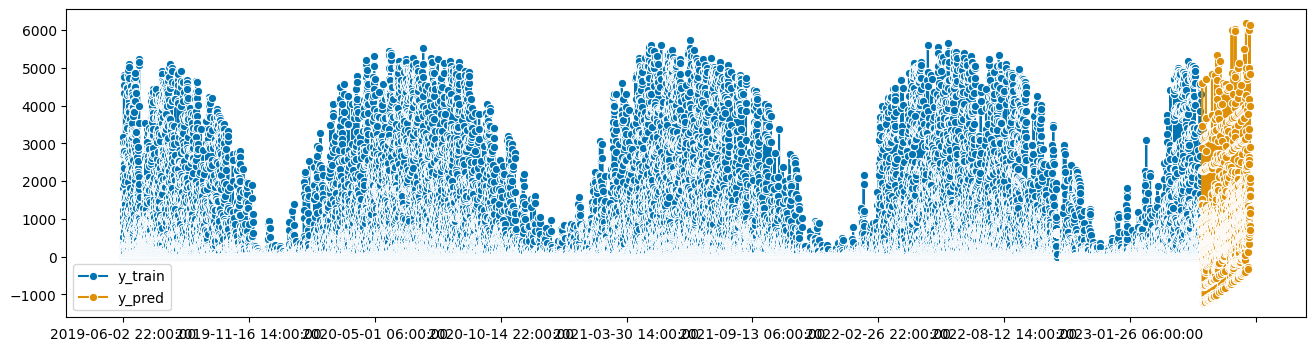

In [ ]:
# plot the forecast
plot_series(y_train, y_pred, labels=["y_train", "y_pred"])

In [278]:
print(X_test.isna().sum())
print((X_test == np.inf).sum())
print((X_test == -np.inf).sum())


air_density_2m:kgm3            0
clear_sky_energy_1h:J          0
clear_sky_rad:W                0
diffuse_rad:W                  0
diffuse_rad_1h:J               0
direct_rad:W                   0
direct_rad_1h:J                0
is_day:idx                     0
is_in_shadow:idx               0
relative_humidity_1000hPa:p    0
sun_elevation:d                0
t_1000hPa:K                    0
dtype: int64
air_density_2m:kgm3            0
clear_sky_energy_1h:J          0
clear_sky_rad:W                0
diffuse_rad:W                  0
diffuse_rad_1h:J               0
direct_rad:W                   0
direct_rad_1h:J                0
is_day:idx                     0
is_in_shadow:idx               0
relative_humidity_1000hPa:p    0
sun_elevation:d                0
t_1000hPa:K                    0
dtype: int64
air_density_2m:kgm3            0
clear_sky_energy_1h:J          0
clear_sky_rad:W                0
diffuse_rad:W                  0
diffuse_rad_1h:J               0
direct_rad:W     

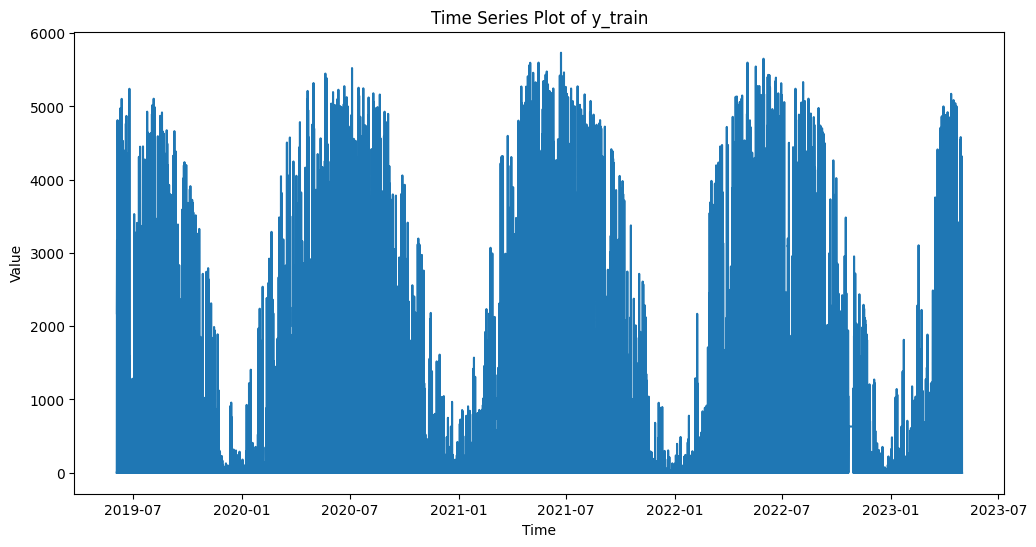

In [281]:
# improve ARIMA model
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train)
plt.title('Time Series Plot of y_train')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


In [282]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

"""
ADF Statistic: -9.919393995916836
p-value: 3.019128612039202e-17
-> Stationary -> d = 0
"""

ADF Statistic: -9.919393995916836
p-value: 3.019128612039202e-17


<Figure size 1200x400 with 0 Axes>

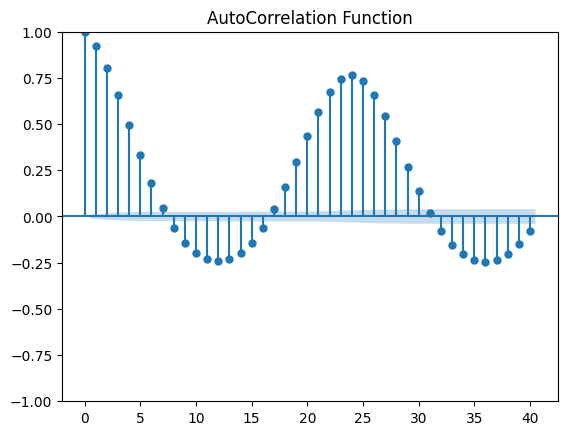

<Figure size 1200x400 with 0 Axes>

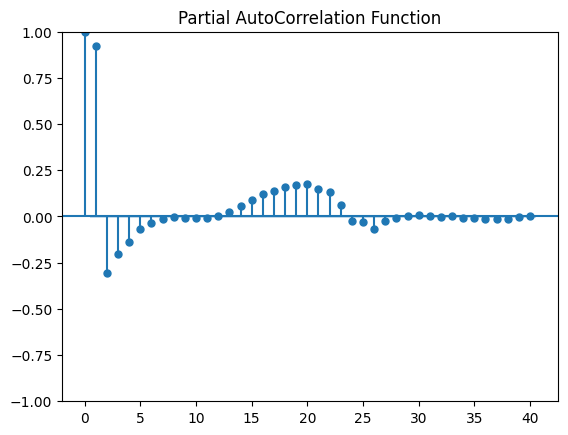

In [283]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# AutoCorrelation Function Plot
plt.figure(figsize=(12, 4))
plot_acf(y_train, lags=40)
plt.title('AutoCorrelation Function')
plt.show()

# Partial AutoCorrelation Function Plot
plt.figure(figsize=(12, 4))
plot_pacf(y_train, lags=40)
plt.title('Partial AutoCorrelation Function')
plt.show()
